# Setup & imports

In [1]:
!pip -q install "gymnasium[atari,accept-rom-license]" stable-baselines3[extra] ale-py shimmy

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from stable_baselines3.common.atari_wrappers import AtariWrapper
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed

In [3]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)
print("ALE registered ✅")

ALE registered ✅


In [5]:
ENV_ID = "ALE/Tennis-v5"
TOTAL_TIMESTEPS = 300_000
EVAL_EPISODES = 20
SEEDS = [0, 1, 2]

LOG_DIR = "./logs_tennis"
MODELS_DIR = "./models_tennis"
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

In [6]:
def make_env(env_id=ENV_ID, seed=0, rank=0):
    def _init():
        gym.register_envs(ale_py)
        env = gym.make(env_id)
        env = Monitor(env)
        env = AtariWrapper(env)
        env.reset(seed=seed + rank)
        env.action_space.seed(seed + rank)
        return env
    return _init

def make_vec_env_dqn(seed=0, n_stack=4):
    set_random_seed(seed)
    venv = DummyVecEnv([make_env(seed=seed, rank=0)])
    venv = VecFrameStack(venv, n_stack=n_stack)
    return venv

In [7]:
import time, gc
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy

class EvalCallbackSimple(BaseCallback):
    def __init__(self, eval_env, eval_freq=100_000, n_eval_episodes=3, seed=0, verbose=0):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes
        self.seed = seed
        self.history = []

    def _on_step(self) -> bool:
        if self.num_timesteps > 0 and self.n_calls % self.eval_freq == 0:
            print(f"[EVAL] t={self.num_timesteps} | seed={self.seed}")
            mean_r, std_r = evaluate_policy(
                self.model, self.eval_env,
                n_eval_episodes=self.n_eval_episodes,
                deterministic=True,
            )
            self.history.append({
                "timesteps": self.num_timesteps,
                "mean_reward": float(mean_r),
                "std_reward": float(std_r),
                "seed": self.seed
            })
        return True


In [8]:
from stable_baselines3 import DQN

def dqn_kwargs(seed):
    return dict(
        learning_rate=1e-4,
        buffer_size=200_000,
        learning_starts=20_000,
        batch_size=32,
        gamma=0.99,
        train_freq=4,
        gradient_steps=1,
        target_update_interval=10_000,
        exploration_fraction=0.20,
        exploration_final_eps=0.01,
        verbose=0,
        seed=seed,
        device="cuda",
    )


In [9]:
def train_dqn(seed=0):
    print("\n" + "="*50)
    print(f"[START] DQN | seed {seed}")
    print("="*50)

    t_seed = time.time()

    env = make_vec_env_dqn(seed=seed)
    eval_env = make_vec_env_dqn(seed=seed+100)

    model = DQN("CnnPolicy", env, **dqn_kwargs(seed))
    cb = EvalCallbackSimple(eval_env, eval_freq=50_000, n_eval_episodes=3, seed=seed)

    t0 = time.time()
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=cb, progress_bar=True)
    learn_time = time.time() - t0
    print(f"[TIME] learn = {learn_time/60:.2f} min")

    t1 = time.time()
    final_mean, final_std = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPISODES, deterministic=True)
    eval_time = time.time() - t1
    print(f"[TIME] final eval = {eval_time:.1f} s")

    # cleanup
    env.close(); eval_env.close()
    del model, env, eval_env
    gc.collect()

    seed_time = time.time() - t_seed
    print(f"[END] DQN | seed {seed} | total = {seed_time/60:.2f} min")

    return cb.history, {
        "algo":"DQN","seed":seed,
        "final_mean":float(final_mean),"final_std":float(final_std),
        "learn_time_s":float(learn_time),"eval_time_s":float(eval_time),
        "seed_time_s":float(seed_time),
    }



In [10]:
import pandas as pd

SEEDS = [0,1,2]

all_hist = []
summary = []

for seed in SEEDS:
    h, s = train_dqn(seed)
    all_hist += [dict(**row, algo="DQN") for row in h]
    summary.append(s)

seed
hist_df = pd.DataFrame(all_hist)
sum_df = pd.DataFrame(summary)

final_table = (
    sum_df.groupby("algo")
    .agg(final_mean_avg=("final_mean","mean"),
         final_mean_std=("final_mean","std"),
         runs=("seed","count"),
         learn_time_min=("learn_time_s", lambda x: x.mean()/60))
    .reset_index()
)

sum_df, final_table



[START] DQN | seed 0


Output()

[EVAL] t=50000 | seed=0

[EVAL] t=100000 | seed=0

[EVAL] t=150000 | seed=0

[EVAL] t=200000 | seed=0

[EVAL] t=250000 | seed=0

[EVAL] t=300000 | seed=0

[TIME] learn = 37.30 min
[TIME] final eval = 41.8 s
[END] DQN | seed 0 | total = 38.08 min

[START] DQN | seed 1


Output()

c:\Users\enzol\anaconda3\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 11.29GB > 5.83GB
  warnings.warn(


[EVAL] t=50000 | seed=1

[EVAL] t=100000 | seed=1

[EVAL] t=150000 | seed=1

[EVAL] t=200000 | seed=1

[EVAL] t=250000 | seed=1

[EVAL] t=300000 | seed=1

[TIME] learn = 40.72 min
[TIME] final eval = 669.9 s
[END] DQN | seed 1 | total = 51.90 min

[START] DQN | seed 2


Output()

c:\Users\enzol\anaconda3\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 11.29GB > 8.11GB
  warnings.warn(


[EVAL] t=50000 | seed=2

[EVAL] t=100000 | seed=2

[EVAL] t=150000 | seed=2

[EVAL] t=200000 | seed=2

[EVAL] t=250000 | seed=2

[EVAL] t=300000 | seed=2

[TIME] learn = 38.78 min
[TIME] final eval = 610.4 s
[END] DQN | seed 2 | total = 48.97 min


(  algo  seed  final_mean  final_std  learn_time_s  eval_time_s  seed_time_s
 0  DQN     0      -23.35   0.852936   2237.873586    41.750625  2285.037679
 1  DQN     1       -4.00   5.805170   2443.208861   669.852178  3114.169228
 2  DQN     2       -1.00   0.000000   2327.080521   610.380564  2938.416210,
   algo  final_mean_avg  final_mean_std  runs  learn_time_min
 0  DQN           -9.45       12.130849     3       38.934239)

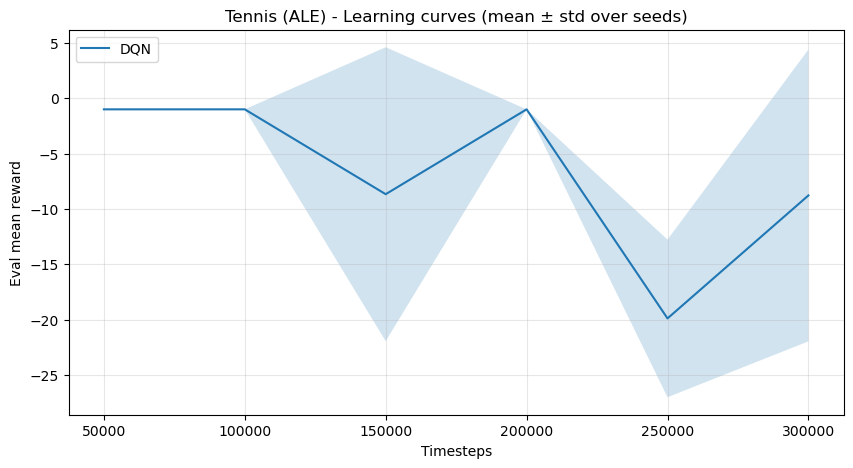

In [11]:
def plot_learning_curves(df):
    plt.figure(figsize=(10,5))
    for algo in df["algo"].unique():
        sub = df[df["algo"] == algo].copy()
        # moyenne par timestep sur seeds
        g = sub.groupby("timesteps")["mean_reward"]
        mean = g.mean()
        std = g.std().fillna(0)
        plt.plot(mean.index, mean.values, label=algo)
        plt.fill_between(mean.index, (mean-std).values, (mean+std).values, alpha=0.2)
    plt.xlabel("Timesteps")
    plt.ylabel("Eval mean reward")
    plt.title("Tennis (ALE) - Learning curves (mean ± std over seeds)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_learning_curves(hist_df)